<a id='top1'></a>
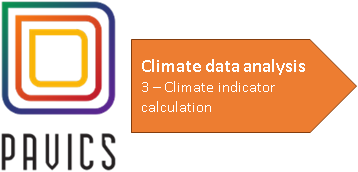


This third tutorial will demonstate PAVICS tools for calculating climate indicators, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS incorporates the <a href="https://xclim.readthedocs.io/en/stable/" target="_blank">xclim</a> library which essentially has two layers for the calculation of indicators. The first `xclim.indices` is a core layer and contains the various algorithms and calculation logic, as well as any potential unit conversions.  A second layer consists of `xclim.core.indicator.Indicator` instances that essentially perform the same computations found in `xclim.indices`, but also run a number of health checks on input data and assign attributes to the output arrays. Indicators are split into realms (`atmos`, `land`, `seaIce`), according to the variables they operate on. 

This tutorial uses the`xclim.atmos` module outlining steps for:

* [Climate indicator calculation](#climcalc)
* [Missing data options](#missing)
* [French language metadata fields](#french)

Advanced topics:

* [Simple multiprocessing of an ensemble](#multiproc)

We re-use part of the data-access and subset tutorials to select a dataset from cb-oura-1.0 datasets from the PAVICS THREDDS server.

<div class="alert alert-info">
To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>
    

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 55152)
Coordinates:
  * lat      (lat) float32 49.29 49.21 49.12 49.04 ... 48.12 48.04 47.96 47.87
  * lon      (lon) float32 -67.71 -67.63 -67.55 -67.46 ... -64.3 -64.21 -64.13
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2100-12-31
Data variables:
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(256, 18, 44), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(256, 18, 44), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(256, 18, 44), meta=np.ndarray>
    crs      int64 1
Attributes: (12/28)
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    CMIP5 compliant file produced from raw ACCESS...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 gr...
    driving_model:              ACCESS1-3
    ...                         ...
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Commonwealth Scientific and Industrial Resear...
    driving_institute_id:       CSIRO-BOM
    driving_model_id:           ACCESS1-3
    crs:                        EPSG:4326

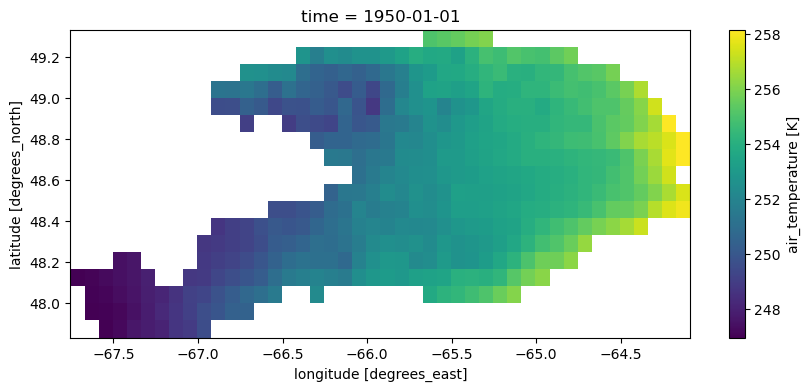

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"  # force use Shapely with GeoPandas

import warnings

import numba

warnings.simplefilter("ignore", category=numba.core.errors.NumbaDeprecationWarning)

import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from clisops.core import subset
from dask.diagnostics import ProgressBar
from siphon.catalog import TDSCatalog
from xclim import atmos

warnings.simplefilter("ignore")
# TODO change address
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"  # TEST_USE_PROD_DATA

# Create Catalog
cat = TDSCatalog(url)

# Subset over the Gaspé peninsula in eastern Quebec
gaspe = gpd.GeoDataFrame.from_file(
    "/notebook_dir/pavics-homepage/tutorial_data/gaspesie_mrc.geojson"
)
ds = subset.subset_shape(
    xr.open_dataset(cat.datasets[0].access_urls["OPENDAP"], chunks=dict(time=256)),
    shape=gpd.GeoDataFrame(geometry=gaspe.buffer(0.05)),
)

# What we see here is only a representation of the full content, the entire data set hasn't been loaded.
display(ds)

# plot of single day tasmin
a = ds.tasmin.isel(time=0).plot(figsize=(10, 4))

<a id='climcalc'></a>
## Climate indicator calculation
The `atmos` module allows us to easily calculate a large number of climate indicators. For example we can determine the projected the number of days with maximum temperature above a threshold for our test dataset using the `atmos.tx_days_above`.  The vast majority of `xclim.atmos` calculations employ a resample frequency parameter `freq` trivializing the calculation of yearly (`'YS'`), monthly (`'MS'`), seasonal (`'QS-DEC'`) or other frequencies following pandas <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases" target="_blank">resampling offsets.</a>


*[return to top of page](#top1)*

calculating yearly output using freq="YS"
[#############################           ] | 72% Completed | 152.73 s

Error:curl error: SSL connect error
curl error details: 


[#############################           ] | 72% Completed | 153.45 s

Error:curl error: Couldn't connect to server
curl error details: 


[#############################           ] | 72% Completed | 154.87 s

Error:curl error: Couldn't connect to server
curl error details: 


[#############################           ] | 72% Completed | 158.13 s

Error:curl error: Couldn't connect to server
curl error details: 


[#############################           ] | 72% Completed | 162.81 s

Error:curl error: Couldn't connect to server
curl error details: 


[#############################           ] | 72% Completed | 175.77 s

Error:curl error: Couldn't connect to server
curl error details: 


[#############################           ] | 72% Completed | 205.80 s


Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 


RuntimeError: NetCDF: I/O failure

Error:curl error: Couldn't connect to server
curl error details: 


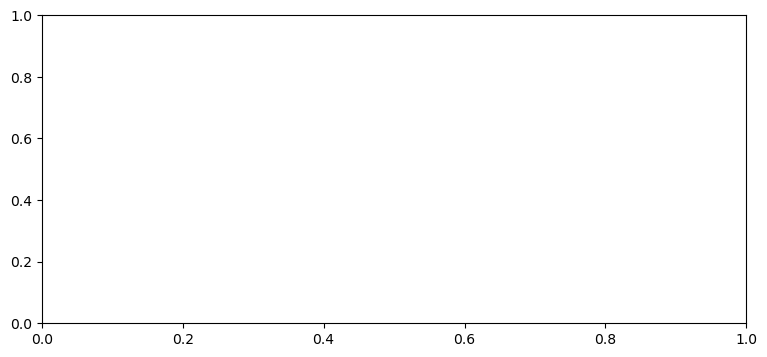

In [2]:
# NBVAL_IGNORE_OUTPUT

freq = "YS"
print(f'calculating yearly output using freq="{freq}"')
with ProgressBar():
    out = atmos.tx_days_above(
        tasmax=ds.tasmax, thresh="27 degC", freq=freq
    )  # Yearly frequency

    # Average over spatial domain and plot time-series
    fig1 = plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    out.mean(dim=["lon", "lat"], keep_attrs=True).plot()
    plt.title("spatial mean")

    # Calculate a 30 year climatology and plot a map
    plt.subplot(1, 2, 2)
    subset.subset_time(out, start_date="1981", end_date="2010").mean(
        dim="time", keep_attrs=True
    ).plot()
    plt.title("1981-2010 mean")
    display()

___
<a id='missing'></a>
### Missing data options
Some data sets require consideration of how best to deal with possible missing data in the input time-series. For example, The World Meteorological Organisation recommends that where monthly means are computed from daily values it should be considered missing if either of these two criteria are met:  observations are missing for 11 or more days during the month; observations are missing for a period of 5 or more consecutive days during the month.  Stricter criteria are sometimes used in practice, with a tolerance of 5 missing values or 3 consecutive missing values, or in other cases one may simply wish to use a simple percent threshold demonstrated below.

The `xclim.set_options` can be used to choose from a number of <a href="https://xclim.readthedocs.io/en/stable/checks.html#missing-values-identification" target="_blank">missing data options</a>.


*[return to top of page](#top1)*

In [3]:
import xclim

# Access some station data
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml"
ds_stat = xr.open_dataset(url, chunks=dict(station=1))
istat = 115
# Compare use of differernt percent tolerance levels  (tolerance == 0.1)
plt.figure(figsize=(15, 10))
color = ["blue", "green", "orange"]

for i, tol in enumerate([0.25, 0.1, 0.05]):
    plt.subplot(3, 1, i + 1)
    with xclim.set_options(
        check_missing="pct", missing_options={"pct": {"tolerance": tol}}
    ):
        # compute yearly max tasmax
        tx_mean = xclim.atmos.tx_mean(
            tasmax=ds_stat.isel(station=istat).tasmax, freq="YS"
        )

        tx_mean.plot(
            marker="o",
            color=color[i],
            label=f"{len(tx_mean.dropna('time').values)} \
                     valid years w/ <={tol*100}% missing data",
        )
        plt.title("")
        plt.xlabel("")
        if i == 0:
            name = str(ds_stat.isel(station=istat).station_name.values)
            plt.title(f"{name.capitalize().replace('_',' ')} Station")

        elif i == 2:
            plt.xlabel("time")

        plt.legend(loc="lower right")

Note:Caching=1
Error:curl error: Couldn't connect to server
curl error details: 


OSError: [Errno -68] NetCDF: I/O failure: b'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml'

<a id='french'></a>
### Adding french language metadata fields

Climate indicator output can be customized to include additional translated metadata fields. French translations are supported directly while others can be user configured. By setting french language <a href="https://xclim.readthedocs.io/en/stable/internationalization.html#" target="_blank">internationalization</a>  options via `xclim.set_options` we note the additional `description_fr` and `longname_fr` attributes. 

*[return to top of page](#top1)*

In [4]:
# NBVAL_IGNORE_OUTPUT

with xclim.set_options(metadata_locales=["fr"]):
    out_fr = atmos.tx_days_above(tasmax=ds.tasmax, thresh="27 degC", freq="YS")
out_fr

<xarray.DataArray 'tx_days_above' (time: 151, lat: 18, lon: 44)>
dask.array<where, shape=(151, 18, 44), dtype=float64, chunksize=(1, 18, 44), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 49.29 49.21 49.12 49.04 ... 48.12 48.04 47.96 47.87
  * lon      (lon) float32 -67.71 -67.63 -67.55 -67.46 ... -64.3 -64.21 -64.13
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2100-01-01
Attributes:
    units:           days
    cell_methods:     time: sum over days
    history:         [2024-01-17 21:01:26] tx_days_above: TX_DAYS_ABOVE(tasma...
    standard_name:   number_of_days_with_air_temperature_above_threshold
    long_name:       The number of days with maximum temperature above 27 degc
    description:     Annual number of days where daily maximum temperature ex...
    long_name_fr:    Nombre de jours ayant une température maximale quotidien...
    description_fr:  Nombre annuel de jours où la température maximale quotid...

___

### Advanced Topics
<a id='multiproc'></a>
#### Parallel processing of the entire ensemble

xclim uses `xarray` and its built-in support of `Dask` parallelization for most of its operations allowing for simple configuration of climate indicator calculation employing <a href="http://xarray.pydata.org/en/stable/dask.html" target="_blank">parallel computing</a>. Here we show a simple workflow to calculate climate indicators for all simulations (n=22) in the `cb-oura-1.0` ensemble.   From a user standpoint simply specifying the `chunks` argument when opening the data via `xarray.open_dataset` will autmomatically result in dask being employed.  In this case, the calculations are additionally computed in parrallel via a `dask.distributed` client of worker processes instead of the default scheduler.


#### User input section
Many PAVICS users may wish to simply calculate a list of custom defined climate indicators over their own region of interest.  The following code section can be edited in order to define :
* The dataset(s) to be used (in this case cb-oura-1.0 thredds catalogue url)
* A subset region of interest (in this case a polygon over Gaspésie)
* A start and end date on which to perform the calculations
* A list of climate indicator calculations to perform (a python list of `xclim.atmos` functions and associated key-word arguments)

*[return to top of page](#top1)*


In [5]:
from pathlib import Path

from dask import compute
from dask.distributed import Client
from IPython.display import clear_output, display

# cb-oura-1.0 thredds url
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"  # TEST_USE_PROD_DATA

# specify output folder for netcdf files
output = "/notebook_dir/writable-workspace/tmp/tutorial3/output"

# Create Catalog
cat = TDSCatalog(url)

# We will subset over the Gaspé peninsula in eastern Quebec
gaspe = gpd.GeoDataFrame.from_file(
    "/notebook_dir/pavics-homepage/tutorial_data/gaspesie_mrc.geojson"
)

# buffer the region slightly (.05 degrees) to include slightly more gridcells than necessary
gaspe = gpd.GeoDataFrame(geometry=gaspe.buffer(0.05))

# calculate on data using start year - if `start_date=None` calculation starts on the intitial timestep
start_date = "1970"

# define an end_date - if `end_date=None` calculation will use the last timestep as an end_date
end_date = None

# Set up a dictionary of xclim.atmos calculations to perform.
# In the example we will calculate two indicators with seasonal and yearly frequency (freq='QS-DEC' and 'YS')
calcs = []

# calculation 1 : seasonal number of days with tmax above 27 degC
calcs.append(
    dict(
        func=atmos.tx_days_above,
        invars=dict(tasmax="tasmax"),
        args=dict(thresh="27 degC", freq="QS-DEC"),
    )
)
# calculation 2 : yearly number of days with tmax above 27 degC
calcs.append(
    dict(
        func=atmos.tx_days_above,
        invars=dict(tasmax="tasmax"),
        args=dict(thresh="27 degC", freq="YS"),
    )
)
# calculation 3: seasonal average maximum daily temperature
calcs.append(
    dict(func=atmos.tx_mean, invars=dict(tasmax="tasmax"), args=dict(freq="QS-DEC"))
)
# calculation 4: yearly average maximum daily temperature
calcs.append(
    dict(func=atmos.tx_mean, invars=dict(tasmax="tasmax"), args=dict(freq="YS"))
)
# Additional calculations added here ...

ConnectionError: HTTPSConnectionPool(host='pavics.ouranos.ca', port=443): Max retries exceeded with url: /twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f7787418160>: Failed to establish a new connection: [Errno 111] Connection refused'))

#### Parallel processing section
The following section of code will execute the calculations prepared above. In many cases the following code can be used as is (or with only slight modifications). It will iteratively prepare a series `dask.delayed` computations on the input datasets found within the THREDDS catalog url (in this case we prepare `dask.delayed` tasks to output one netcdf file per simulation per climate indicator calculation). Then, employing a dask distributed `Client`, simulataneously execute all calculations in parralel. Climate indicator calculation output netcdf files are written into an `output` subfolder.

<div class="alert alert-info"><strong>Info!</strong> Despite increased performance via parallel processing executing this portion of the tutorial will likely take some time to finish all computations.
</div>

In [6]:
# NBVAL_SKIP


# We define a small sub-function for xclim.atmos indicator calculation and export to netcdf.
# compute=False results in returning a dask.delayed object : computation is not immediately executed.
# dask.delayed objects for all calculations are appended to a list and executed in parralel all at once
def indicator_calc(func, outfile, args, attrs):
    dsout = xr.Dataset(attrs=attrs)
    out = func(**args)
    dsout[out.name] = out
    return dsout.to_netcdf(outfile, mode="w", compute=False)


# Parallel computing part...
dask_kwargs = dict(
    n_workers=6,
    threads_per_worker=6,
    memory_limit="4GB",
    local_directory="/notebook_dir/writable-workspace/tmp",
)
with Client(**dask_kwargs) as client:
    # loop over the list of calculations to perform
    for c in calcs:
        # create an output file prefix from the input arguments
        prefix = "-".join(
            [f"{c['args'][c1]}" for c1 in c["args"] if type(c["args"][c1]) == str]
        )

        # we also add the xclim.atmos function identifier to the file prefix
        prefix = f"{c['func'].identifier}_{prefix.replace(' ','_')}"

        # Loop over all climate simulations in the ensemble:
        # We'll create a list of dask.delayed calculations that will be subsequently sent to the Client for computation
        jobs = []
        for i, d in enumerate([cat.datasets[x] for x in cat.datasets]):
            clear_output(wait=True)
            print(
                f"preparing calculation {i+1} of {len([cat.datasets[x] for x in cat.datasets])} for {prefix}... "
            )

            # create the output file path
            # We will write to a 'output' subdirectory
            outfile = Path(output).joinpath(
                d.name.replace("day_", f"{prefix}_")
                .replace("1950", start_date)
                .replace(".ncml", ".nc")
            )

            # create the output dir if not already present
            outfile.parent.mkdir(parents=True, exist_ok=True)

            # access the climate simulation data from thredds
            ds = xr.open_dataset(d.access_urls["OPENDAP"], chunks=dict(time=256 * 15))
            # subset the dataset
            ds = subset.subset_shape(
                ds, shape=gaspe, start_date=start_date, end_date=end_date
            )
            # add the subsetted dataset to the list of input arguments
            args = c["args"]
            for v, vv in c["invars"].items():
                args[v] = ds[vv]
            # call our custom sub-function with the arguments and data
            # append the returned dask.delayed object to our list
            jobs.append(indicator_calc(c["func"], outfile, args, ds.attrs))

        # send the entire list of dask.delayed to the Client for calculation
        print("computing with dask client ...")
        compute(jobs)
        print("finished")
        # optionally restart the client when finished (can help ensure good memory management)
        client.restart()

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38219
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36778'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35209'
Error:curl error: Couldn't connect to server
curl error details: 
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44745'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38609'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45118'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36995'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:32899', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:32899
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:53224
INFO:distributed.scheduler:Register w

NameError: name 'calcs' is not defined

___
### Notes

<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

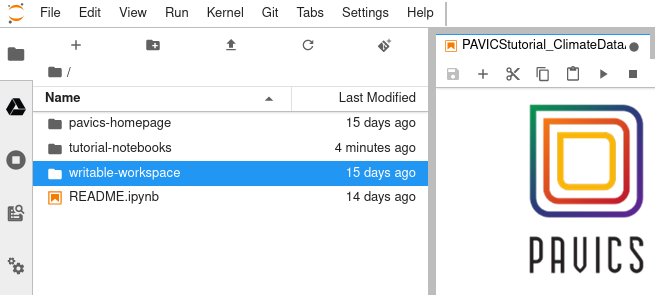

*[return to top of page](#top1)*